In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
# %matplotlib tk
we_keys = [0, 10]
eff_keys = [0, 0.2, 0.6, 1]
db_keys = [0, 1, 10, 100]


In [5]:
import pandas as pd

# Dataframe from csv
df = pd.read_csv("EGG_DATA_bis/report_2024_04_22_09_45.csv")
df["dir"] = df["dir"].apply(lambda x: int(x))
# Time to survival -1 to inf
for i in range(5):
    df[f"time_to_survival_agent_{i}"] = df[f"time_to_survival_agent_{i}"].apply(lambda x: np.infty if x == -1 else x)
    df[f"time_to_survival_agent_sd{i}"] = df[f"time_to_survival_agent_sd{i}"].apply(lambda x: np.infty if x == -1 else x)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 44 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   db                          18 non-null     float64
 1   eff_rate                    18 non-null     float64
 2   we                          18 non-null     float64
 3   dir                         18 non-null     int64  
 4   mean_reward                 18 non-null     float64
 5   mean_reward_agent_0         18 non-null     float64
 6   mean_reward_agent_1         18 non-null     float64
 7   mean_reward_agent_2         18 non-null     float64
 8   mean_reward_agent_3         18 non-null     float64
 9   mean_reward_agent_4         18 non-null     float64
 10  mean_mo_reward_agent_v0_0   18 non-null     float64
 11  mean_mo_reward_agent_v0_1   18 non-null     float64
 12  mean_mo_reward_agent_v0_2   18 non-null     float64
 13  mean_mo_reward_agent_v0_3   18 non-nu

In [6]:
df[[f"time_to_survival_agent_{i}" for i in range(5)]]

,time_to_survival_agent_0,time_to_survival_agent_1,time_to_survival_agent_2,time_to_survival_agent_3,time_to_survival_agent_4
0,476.50,458.25,418.50,430.25,413.75
1,179.12,NaN,429.50,428.50,478.00
2,150.00,NaN,NaN,NaN,NaN
3,247.50,268.25,283.75,NaN,NaN
4,161.38,173.12,183.75,NaN,NaN
5,195.88,161.38,225.25,187.62,215.00
6,421.25,438.00,420.25,434.00,434.25
7,165.38,371.75,438.75,366.75,413.00
8,188.62,148.38,191.00,254.12,242.00
9,331.75,314.75,266.00,243.00,292.50


In [7]:
# Pretty print table with eff, db, we and dir
df[["eff_rate", "db", "we", "dir"]]

,eff_rate,db,we,dir
0,0.0,0.0,10.0,0
1,0.2,0.0,10.0,0
2,0.2,0.0,0.0,0
3,0.6,0.0,10.0,4
4,0.6,0.0,0.0,0
5,1.0,0.0,10.0,1
6,0.0,1.0,10.0,0
7,0.2,1.0,10.0,3
8,0.6,1.0,10.0,1
9,1.0,1.0,10.0,1


In [8]:
df_numpy = df.to_numpy()
ref_policies_df = df[df["we"] == 10]

# Reference policies: we = 10
ref_policies_values = {
    eff: {db: np.zeros((5,2)) for db in db_keys} for eff in eff_keys
}
ref_policies_np = df_numpy[df_numpy[:, 2] == 10]

for i in range(len(ref_policies_np)):
    eff = ref_policies_np[i][1]
    db = ref_policies_np[i][0]
    ref_policies_values[eff][db] = np.hstack([ref_policies_np[i][10:15].reshape((5,1)), ref_policies_np[i][15:20].reshape((5,1)) ])

ref_policies_values[0.6][1] = np.array([[-1.3750e+02,  7.3400e+00],[-1.3025e+02,  5.2600e+00],[-1.3400e+02,  7.1700e+00],[-2.5138e+02,  1.0000e-02],[-2.4075e+02,  3.0000e-02]])   

ref_policies_values[0.2][1]

array([[-132.88,   31.8 ],
       [-372.25,    0.  ],
       [-473.75,    0.  ],
       [-367.5 ,    0.  ],
       [-429.5 ,    0.  ]])

In [9]:
ref_policies_values[0.6][1]

array([[-1.3750e+02,  7.3400e+00],
       [-1.3025e+02,  5.2600e+00],
       [-1.3400e+02,  7.1700e+00],
       [-2.5138e+02,  1.0000e-02],
       [-2.4075e+02,  3.0000e-02]])

In [10]:
unet_policies_values = {
    eff: np.zeros((5,2)) for eff in eff_keys
}

unet_policies_np = df_numpy[df_numpy[:, 2] == 0]
for i in range(len(unet_policies_np)):
    eff = unet_policies_np[i][1]
    unet_policies_values[eff] = np.hstack([unet_policies_np[i][10:15].reshape((5,1)), unet_policies_np[i][15:20].reshape((5,1)) ])
unet_policies_values[0] = ref_policies_values[0][0]
unet_policies_values[1] = ref_policies_values[1][0]
unet_policies_values[0.6]

array([[-9.8810e+01, -1.1000e-01],
       [-1.1938e+02, -2.9500e+00],
       [-1.3312e+02, -8.8000e-01],
       [-4.9825e+02,  0.0000e+00],
       [-4.9825e+02,  0.0000e+00]])

In [11]:
# Function to get the intersection of two lines represented as f(we) = v0 + we*ve for a two given fixed sets of (v0, ve)
def get_intersection(v01, ve1, v02, ve2):
    if ve1 == ve2:
        return 0
    we = (v01 - v02) / (ve2 - ve1)
    return we
# get_intersection(mo_value_w10[2][0], mo_value_w10[2][1], mo_value_w0[2][0], mo_value_w0[2][1])

5.193288590604026
1.3239951278928141
0.10931677018633483
-24687.0
-8583.333333333334


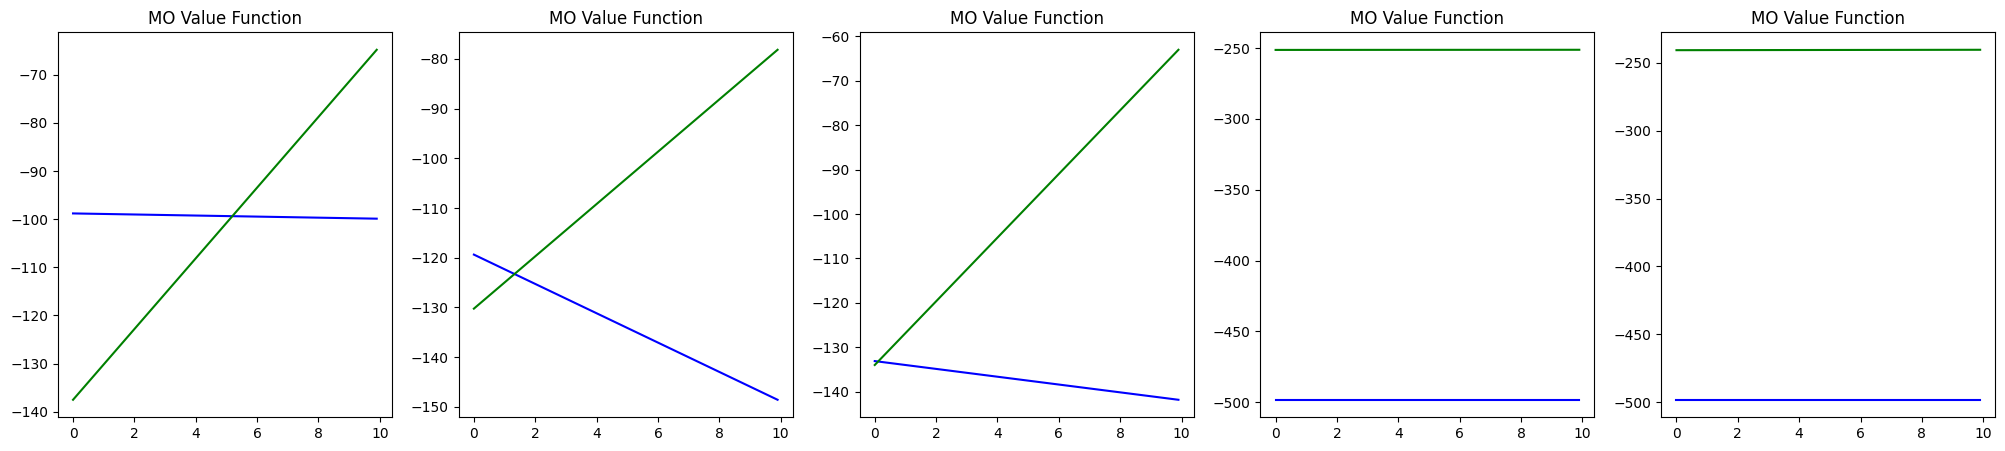

In [12]:
# Plot values as function of weight w that scales the reward
fig, axs = plt.subplots(1, 5, figsize=(25, 5)) 
step = 0.1
# for ag in mo_value_w10:
max_weight = 10
# Subplot for each agent
x = np.arange(0, max_weight, step)
w = np.array([np.ones(int(max_weight/step)), np.arange(0, max_weight, step)])

setting = {"eff": 0.6, "db": 1}
for ag in range(5):
    axs[ag].set_title("MO Value Function")
    ref = ref_policies_values[setting["eff"]][setting["db"]]
    unet = unet_policies_values[setting["eff"]]
    axs[ag].plot(x, np.dot(unet[ag], w), c="blue")
    axs[ag].plot(x, np.dot(ref[ag], w), c="green")
    
wes = []
for ag in range(5):
    # Print intersecctions
    p1 = unet_policies_values[setting["eff"]][ag]
    p2 = ref_policies_values[setting["eff"]][setting["db"]][ag]
    inter = get_intersection(p1[0], p1[1], p2[0], p2[1])
    print(inter)
    wes.append(inter)
plt.show()

In [13]:
print(ref_policies_values[0.6][0][0:3])
print(ref_policies_values[0.6][1][0:3])
print(ref_policies_values[0.6][10][0:3])
print(ref_policies_values[0.6][100][0:3])

[[-214.75    0.  ]
 [-272.75    0.  ]
 [-277.5     0.  ]]
[[-137.5     7.34]
 [-130.25    5.26]
 [-134.      7.17]]
[[-141.      9.25]
 [-134.12    9.38]
 [-148.12    8.32]]
[[-163.62   18.56]
 [-169.25   25.19]
 [-154.88   28.44]]


In [14]:
def compute_wes_prima(eff, db):
    def aggregation_function(wes, method="median"):
        # cut to interval 1-10 else return -inf
        wes = [w for w in wes if w >= 1 and w <= 10]
        if len(wes) == 0:
            return 0
        if method == "median":
            return np.median(wes)
        if method == "mean":
            return np.mean(wes)
        if method == "max":
            return np.max(wes)
        if method == "min":
            return np.min(wes)
    wes_prima = []
    for ag in range(5):
        # Print intersecctions
        p1 = unet_policies_values[eff][ag]
        p2 = ref_policies_values[eff][db][ag]
        inter = get_intersection(p1[0], p1[1], p2[0], p2[1])
        wes_prima.append(inter)
    return aggregation_function(wes_prima, method="median")


# Create table of WES' for each eff (from 0.2, 0.6, 1) and db (from 0, 1, 10, 100) 
wes_prima = {
    db: {eff: compute_wes_prima(eff, db) for eff in eff_keys} for db in db_keys
}
# pretty print as dataframe
wes_df = pd.DataFrame(wes_prima)
wes_df

,0,1,10,100
0.0,0,0.000000,0.000000,0.000000
0.2,0,1.658904,1.546498,1.693273
0.6,0,3.258642,1.630435,2.621777
1.0,0,0.000000,7.564576,4.609557


In [15]:
time2survival_np = ref_policies_np[:, 20:25]
time2survival_std_np = ref_policies_np[:, 25:30]
# Create a string with the mean and std of the time to survival for each agent
mean_std_time2survival = {(eff, db): [] for eff in eff_keys for db in db_keys}
for i in range(len(time2survival_np)):
    eff = ref_policies_np[i][1]
    db = ref_policies_np[i][0]
    for ag in range(5):
        mean_std_time2survival[eff, db].append(f"{time2survival_np[i][ag]:.2f} ± {time2survival_std_np[i][ag]:.2f}")
        
# pretty print as dataframe
mean_std_time2survival[0.2, 10]

['152.25 ± 42.69',
 '381.00 ± 59.31',
 '384.75 ± 54.97',
 '385.50 ± 56.06',
 '387.00 ± 54.19']

In [16]:
# Print time 2 survive with agent groups of eff 
grouped_time2survival = []
percentage = False
for eff in [0.2, 0.6]:
    for db in [0, 1, 10, 100]:
        row = [eff, db] 
        agents_t2s = list(time2survival_np[(ref_policies_np[:, 1] == eff) & (ref_policies_np[:, 0] == db)].mean
                          (axis=0))
        agents_t2s_std = list(time2survival_std_np[(ref_policies_np[:, 1] == eff) & (ref_policies_np[:, 0] == db)].mean(axis=0))
        if percentage:
            eff_group = np.mean(agents_t2s[:int(5*eff)]) * 100 / 500
            uneff_group = np.mean(agents_t2s[int(5*eff):])* 100 / 500
        else:
            eff_group = np.mean(agents_t2s[:int(5*eff)])
            uneff_group = np.mean(agents_t2s[int(5*eff):])
            # std 
        eff_group_std = np.mean(agents_t2s_std[:int(5*eff)])
        uneff_group_std = np.mean(agents_t2s_std[int(5*eff):])
        row += [eff_group, eff_group_std, uneff_group, uneff_group_std]
        grouped_time2survival.append(row)
        
grouped_time2survival = np.array(grouped_time2survival)
grouped_time2survival_df = pd.DataFrame(grouped_time2survival, columns=["eff", "db", "eff_group", "eff_group_std", "uneff_group", "uneff_group_std"])
grouped_time2survival_df

,eff,db,eff_group,eff_group_std,uneff_group,uneff_group_std
0,0.2,0.0,179.12,80.310000,NaN,NaN
1,0.2,1.0,165.38,46.470000,397.5625,58.3375
2,0.2,10.0,152.25,42.690000,384.5625,56.1325
3,0.2,100.0,163.12,63.190000,381.1250,58.8600
4,0.6,0.0,266.50,83.460000,NaN,NaN
5,0.6,1.0,176.00,46.966667,248.0600,31.1950
6,0.6,10.0,181.04,56.216667,247.6250,34.1750
7,0.6,100.0,178.58,50.793333,248.3100,33.5600


In [17]:
agents_t2s_std

[51.22, 53.91, 47.25, 32.84, 34.28]

In [18]:
#print ratio of survival
ratio_survival_np = ref_policies_np[:, 30:35]
ratio_survival = np.zeros((4,4,5))

for i in range(len(ratio_survival_np)):
    #map eff to eff_keys ind
    eff = ref_policies_np[i][1]
    db = ref_policies_np[i][0]
    ratio_survival[eff_keys.index(eff), db_keys.index(db)] = ratio_survival_np[i]
    
# Print as table with rows of format eff, db, ratio of survival for each agent
ratio_survival = ratio_survival.reshape((16,5))
survival_rate_df = pd.DataFrame(ratio_survival, columns=[f"Agent {i}" for i in range(5)], index=[f"{int(eff*100)}\%, {db}" for eff in eff_keys for db in db_keys])

In [19]:
# Print table of the gini
max_gini_value = 1 - 1/5
gini = {
    db: {eff: df[(df['we'] == 10) & (df['eff_rate'] == eff) & (df['db'] == db)]["gini"].to_numpy()/max_gini_value for eff in eff_keys} for db in db_keys
}
pd.DataFrame(gini)

,0,1,10,100
0.0,[0.95],[0.95],[0.95],[0.9375]
0.2,[0.6],[0.95],[1.0],[0.9875]
0.6,[0.825],[0.95],[0.95],[1.0]
1.0,[0.9875],[0.9625],[0.9875],[1.0]


In [20]:
# Print table of the hoover
max_hoover_value = 1
hoover = {
    db: {eff: df[(df['we'] == 10) & (df['eff_rate'] == eff) & (df['db'] == db)]["hoover"].to_numpy() for eff in eff_keys} for db in db_keys
}
pd.DataFrame(hoover).to_numpy()

array([[array([0.17]), array([0.19]), array([0.18]), array([0.2])],
       [array([0.49]), array([0.15]), array([0.02]), array([0.06])],
       [array([0.36]), array([0.2]), array([0.19]), array([0.01])],
       [array([0.11]), array([0.16]), array([0.1]), array([0.])]],
      dtype=object)

In [21]:
import numpy as np
from tabulate import tabulate

gini = np.array([[np.array([], dtype=np.float64), np.array([0.18]), np.array([0.18]),
        np.array([0.2])],
       [np.array([0.48]), np.array([0.15]), np.array([0.02]), np.array([0.05])],
       [np.array([0.35]), np.array([0.2]), np.array([0.19]), np.array([0.])],
       [np.array([0.11]), np.array([0.18]), np.array([0.1]), np.array([0.])]],
      dtype=object)

def numpy_to_latex(array):    
    latex_table = tabulate(array, tablefmt="latex_raw", headers=db_keys, showindex=eff_keys)
    return latex_table

print(numpy_to_latex(gini))

\begin{tabular}{rlrrr}
\hline
     & 0      &    1 &   10 &   100 \\
\hline
 0   & []     & 0.18 & 0.18 &  0.2  \\
 0.2 & [0.48] & 0.15 & 0.02 &  0.05 \\
 0.6 & [0.35] & 0.2  & 0.19 &  0    \\
 1   & [0.11] & 0.18 & 0.1  &  0    \\
\hline
\end{tabular}


In [22]:
list(survival_rate_df.columns)

['Agent 0', 'Agent 1', 'Agent 2', 'Agent 3', 'Agent 4']

In [23]:
tab = tabulate(survival_rate_df.to_numpy(), tablefmt="latex_raw", headers=list(survival_rate_df.columns), showindex=list(survival_rate_df.index))
print(tab)

\begin{tabular}{lrrrrr}
\hline
            &   Agent 0 &   Agent 1 &   Agent 2 &   Agent 3 &   Agent 4 \\
\hline
 0\%, 0     &      0.01 &      0.04 &      0.01 &      0.01 &      0.03 \\
 0\%, 1     &      0.02 &      0.03 &      0.08 &      0.11 &      0.04 \\
 0\%, 10    &      0    &      0    &      0.01 &      0    &      0    \\
 0\%, 100   &      0    &      0    &      0.22 &      0.06 &      0.02 \\
 20\%, 0    &      0.88 &      0    &      0.06 &      0.07 &      0    \\
 20\%, 1    &      1    &      0.96 &      0.36 &      0.96 &      0.76 \\
 20\%, 10   &      1    &      0.94 &      0.95 &      0.94 &      0.93 \\
 20\%, 100  &      0.98 &      0.88 &      0.8  &      0.82 &      0.54 \\
 60\%, 0    &      0.97 &      0.84 &      0.89 &      0    &      0    \\
 60\%, 1    &      1    &      1    &      1    &      1    &      1    \\
 60\%, 10   &      1    &      1    &      1    &      1    &      1    \\
 60\%, 100  &      1    &      1    &      1    &      1    & 

In [24]:
# Print table of n_survivors
n_survivors_np = {
    db: {eff: f"{df[(df['we'] == 10) & (df['eff_rate'] == eff) & (df['db'] == db)]['n_survivors'].to_numpy() / 5 * 100}\%" for eff in eff_keys} for db in db_keys
}
pd.DataFrame(n_survivors_np)

tab = tabulate(pd.DataFrame(n_survivors_np).to_numpy(), tablefmt="latex_raw", headers=db_keys, showindex=eff_keys)
print(tab)

\begin{tabular}{rllll}
\hline
     & 0        & 1        & 10       & 100      \\
\hline
 0   & [2.]\%   & [5.4]\%  & [0.4]\%  & [6.]\%   \\
 0.2 & [20.4]\% & [81.]\%  & [95.2]\% & [80.2]\% \\
 0.6 & [54.]\%  & [100.]\% & [99.8]\% & [100.]\% \\
 1   & [99.4]\% & [89.8]\% & [100.]\% & [100.]\% \\
\hline
\end{tabular}


In [25]:
# Print grouped time to survival as latex table
tab = tabulate(grouped_time2survival_df.to_numpy().round(2), tablefmt="latex_raw", headers=grouped_time2survival_df.columns, showindex=False)
print(tab)

\begin{tabular}{rrrrrr}
\hline
   eff &   db &   eff_group &   eff_group_std &   uneff_group &   uneff_group_std \\
\hline
   0.2 &    0 &      179.12 &           80.31 &        nan    &            nan    \\
   0.2 &    1 &      165.38 &           46.47 &        397.56 &             58.34 \\
   0.2 &   10 &      152.25 &           42.69 &        384.56 &             56.13 \\
   0.2 &  100 &      163.12 &           63.19 &        381.12 &             58.86 \\
   0.6 &    0 &      266.5  &           83.46 &        nan    &            nan    \\
   0.6 &    1 &      176    &           46.97 &        248.06 &             31.2  \\
   0.6 &   10 &      181.04 &           56.22 &        247.62 &             34.17 \\
   0.6 &  100 &      178.58 &           50.79 &        248.31 &             33.56 \\
\hline
\end{tabular}


In [26]:
# Print wes
tab = tabulate(wes_df.to_numpy().round(2), tablefmt="latex_raw", headers=wes_df.columns, showindex=eff_keys)
print(tab)

\begin{tabular}{rrrrr}
\hline
     &   0 &    1 &   10 &   100 \\
\hline
 0   &   0 & 0    & 0    &  0    \\
 0.2 &   0 & 1.66 & 1.55 &  1.69 \\
 0.6 &   0 & 3.26 & 1.63 &  2.62 \\
 1   &   0 & 0    & 7.56 &  4.61 \\
\hline
\end{tabular}


In [27]:
events = ["did_not_donate", "greedy"]
# Build table with number of actions for each event separated by reference policies
unethical_actions = np.zeros((4, 4, 2))
for i in range(len(df_numpy)):
    eff = df_numpy[i][1]
    db = df_numpy[i][0]
    for j, event in enumerate(events):
        unethical_actions[eff_keys.index(eff), db_keys.index(db), j] = df_numpy[i][j+38]
unethical_actions = unethical_actions * 100 / 500  
unethical_actions = np.round(unethical_actions, 2)
# Print latex rows as eff, (did_not_donate, greedy) for each db
for i in range(4):
    s = f"{int(eff_keys[i]*100)}\% & "
    for j in range(4):
        s += "{:.2f}\% & {:.2f}\% & ".format(unethical_actions[i, j, 0], unethical_actions[i, j, 1])
    print(s[:-2] + "\\\\")


0\% & 0.00\% & 0.00\% & 0.44\% & 0.00\% & 0.00\% & 0.00\% & 0.58\% & 0.00\% \\
20\% & 0.00\% & 0.24\% & 0.72\% & 0.00\% & 0.32\% & 0.00\% & 6.73\% & 0.00\% \\
60\% & 0.00\% & 0.16\% & 0.13\% & 0.00\% & 0.43\% & 0.00\% & 0.09\% & 0.00\% \\
100\% & 0.00\% & 0.00\% & 35.02\% & 0.00\% & 0.48\% & 0.00\% & 0.08\% & 0.00\% \\
